In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [ ]:
import glob

In [ ]:
from pydub import AudioSegment

In [ ]:
#| hide
!nbdev_install_hooks

Hooks are installed.


# 人声增强

目标:从一段音频中增强人声

## 人声读取

### 位置

利用glob获取每一个data的位置

In [ ]:
voiceset = L(glob.glob('/ailearn/own/daily/dataset/dataset/voice_dataset/cv-corpus-11.0-delta-2022-09-21/en/clips/*.mp3'))

In [ ]:
voiceset[0]

'/ailearn/own/daily/dataset/dataset/voice_dataset/cv-corpus-11.0-delta-2022-09-21/en/clips/common_voice_en_34451548.mp3'

### 读取

使用pydub读取声音

In [ ]:
mp3 = AudioSegment.from_mp3(voiceset[0])

In [ ]:
mp3

读取成功

### 转换

In [ ]:
arr = np.frombuffer(mp3.raw_data, dtype='int16')

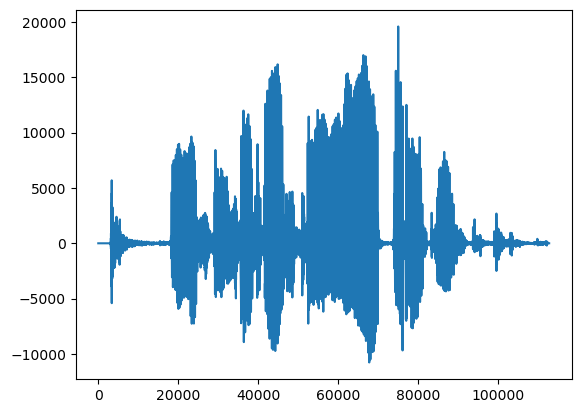

In [ ]:
plt.plot(arr)
plt.show()

In [ ]:
mp3.frame_rate

32000

### 组合

In [ ]:
def getmp3raw(path):
    mp3 = AudioSegment.from_mp3(path).set_frame_rate(32000)
    return np.frombuffer(mp3.raw_data, dtype='int16')#,mp3.frame_rate

### 导出

In [ ]:
def exportwav(name, rate, arr):
    arr.astype(np.int16)
    scipy.io.wavfile.write(name, rate, arr)

## 环境声提取

### 位置

使用ESC-50数据集

In [ ]:
voiceset2 = L(glob.glob('/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/*.wav'))

In [ ]:
voiceset2

(#2000) ['/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/4-195707-A-13.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/3-187710-A-11.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/4-204777-C-39.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/2-135649-A-45.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/1-90797-A-15.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/4-181955-A-3.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/1-22694-A-20.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/4-119648-D-48.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/1-56380-B-5.wav','/ailearn/own/daily/dataset/dataset/voice_dataset/ESC-50-master/audio/2-83536-A-27.wav'...]

### 读取函数

这边把所有文件都变成32000的采样率

In [ ]:
def getwavraw(path):
    wav = AudioSegment.from_wav(path).set_frame_rate(32000)
    return np.frombuffer(wav.raw_data, dtype='int16')#,wav.frame_rate

## 声音合成

将两段声音加起来,就是叠加了

这个函数输入两个数组,返回相同长度的三个数组

In [ ]:
def getsumvoice(voice0,voice1):
    a = len(voice0)
    b = len(voice1)
    if a>b:
        voice0 = voice0[:b]
    else:
        voice1 = voice1[:a]
    voice2 = voice1+voice0
    
    return voice0,voice1,voice2

## 播放numpy

In [ ]:
def playarr(arr,rate=32000):
    arr = array(arr)
    arr = arr.astype(np.int16)
    exportwav('temp/test.wav',rate,arr)
    return AudioSegment.from_wav('temp/test.wav')

## 训练

### 随机生成拼合数据

它的输出需要为频谱图,也就是进行stft处理

并且,长宽得可以整除除32

并且,需要变成同一大小以方便处理

In [ ]:
def getrandsum(num, vset0=voiceset, vset1=voiceset2):
    k = []
    for _ in range(num):
        # 随机生成数字
        i = random.randint(0, len(vset0)-1)
        j = random.randint(0, len(vset1)-1)
        # 获取数据
        arr0 = getmp3raw(vset0[i]).astype(np.float32())
        arr1 = getwavraw(vset1[j]).astype(np.float32())
        arr0, arr1, arr2 = getsumvoice(arr0, arr1)
        # 生成
        arr0 = tensor(arr0.copy()).reshape(-1)
        arr2 = tensor(arr2.copy()).reshape(-1)

        arr0 = torch.stft(arr0, 511, return_complex=False)
        arr2 = torch.stft(arr2, 511, return_complex=False)

        o = torch.zeros((256, 1344, 2))
        p = torch.zeros((256, 1344, 2))

        if arr0.shape[1] < 1344:
            #print(arr0.shape[1])
            o[:, :arr0.shape[1]] = arr0
            p[:, :arr0.shape[1]] = arr2
        else:
            #print(arr0.shape[1])
            o = arr0[:, :1344]
            p = arr2[:, :1344]
        # arr0 = arr0[:, :-(arr0.shape[1] % 32), :]
        # arr2 = arr2[:, :-(arr2.shape[1] % 32), :]

        k.append([o, p])
    return k

In [ ]:
x = getrandsum(1, voiceset,voiceset2)

In [ ]:
x[0][0].shape

torch.Size([256, 1344, 2])

### 逆处理至音频

In [ ]:
destft = (lambda x:torch.istft(x, 511,return_complex=False))

### 生成数据集

使用fastai的数据块

In [ ]:
dl = DataBlock(
    get_items=getrandsum,
    get_x=(lambda x:x[1]),
    get_y=(lambda x:x[0])
)

### 检查数据

In [ ]:
x = dls.dataset[0][0]

In [ ]:
y = dls.dataset[0][1]

/tmp/ipykernel_364/968818733.py:1: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at /var/lib/jenkins/pytorch/aten/src/ATen/native/SpectralOps.cpp:978.)
  destft = (lambda x:torch.istft(x, 511,return_complex=False))


[<matplotlib.lines.Line2D>]

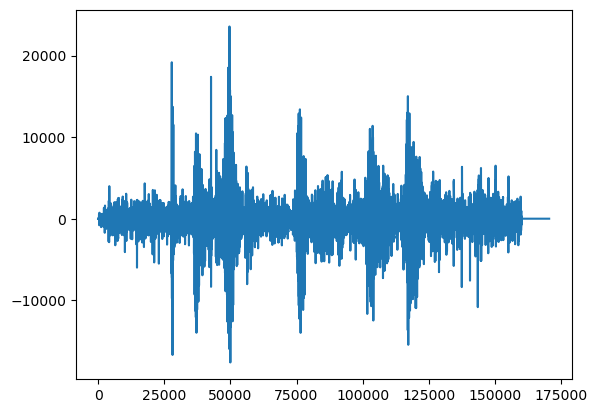

In [ ]:
plt.plot(destft(x))

[<matplotlib.lines.Line2D>]

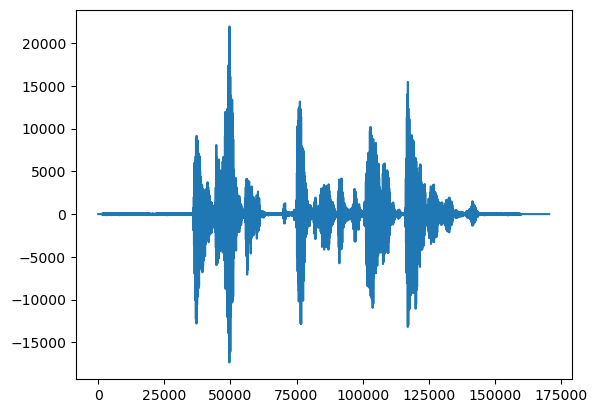

In [ ]:
plt.plot(destft(y))

In [ ]:
dls.dataset[0][0].shape

torch.Size([256, 1344, 2])

### 定义模型

一个简单的Unet

目标:  
识别噪音 -> 产生掩盖 -> 相乘

因为Unet的特性,它应当可以识别到噪音的特征,并反向至目标

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(Decoder, self).__init__()
        
        self.up = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv_relu = nn.Sequential(
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        
        x1 = self.up(x1)
        # print(x1.shape,x2.shape)
        x1 = torch.cat((x1, x2), dim=1)
        x1 = self.conv_relu(x1)
        return x1

In [ ]:
import torchvision

注意:下采样时需要使输出为偶数尺寸  

并且最好在输入数据时进行标准化-对数缩放

In [ ]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.base_model = torchvision.models.resnet18(True)  # 不使用预训练模型
        self.base_layers = list(self.base_model.children())

        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(  # 数据有两个通道
                2, 2), padding=(3, 3), bias=False),
            self.base_layers[1],
            self.base_layers[2])

        self.layer2 = nn.Sequential(*self.base_layers[3:5])
        self.layer3 = self.base_layers[5]
        self.layer4 = self.base_layers[6]
        self.layer5 = self.base_layers[7]

        self.decode4 = Decoder(512, 256+256, 256)
        self.decode3 = Decoder(256, 256+128, 256)
        self.decode2 = Decoder(256, 128+64, 128)
        self.decode1 = Decoder(128, 64+64, 64)

        self.decode0 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        )

        self.conv_last = nn.Conv2d(64, 2, 1)  # 这边转换为二通道数据

    def forward(self, inp):
        # 输入: 1,257,1251,2

        inp = inp.permute(0, 3, 1, 2)  # 输入: 1,2,257,1251

        e1 = self.layer1(
            torch.log1p(inp.abs())
        )  # 64,128,128

        e2 = self.layer2(e1)  # 64,64,64
        e3 = self.layer3(e2)  # 128,32,32
        e4 = self.layer4(e3)  # 256,16,16
        # print(inp.shape)
        # print('e1',e1.shape)
        # print('e2',e2.shape)
        # print('e3',e3.shape)
        # print('e4',e4.shape)
        f = self.layer5(e4)  # 512,8,8
        # print(f.shape)
        d4 = self.decode4(f, e4)  # 256,16,16
        d3 = self.decode3(d4, e3)  # 256,32,32
        d2 = self.decode2(d3, e2)  # 128,64,64
        d1 = self.decode1(d2, e1)  # 64,128,128
        d0 = self.decode0(d1)  # 64,256,256

        out = self.conv_last(d0)  # 1,256,256
        #out = F.relu(out)

        out = inp*out
        out = out.permute(0, 2, 3, 1)

        return out

实际上,直接abs再log1p其实并没有那么合理

理论上来讲,需要把负数和正数分开

In [ ]:
m = Unet()

/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 训练

In [ ]:
dls = dl.dataloaders(128,bs=4)

In [ ]:
learn = Learner(dls,
               m,
               loss_func=MSELossFlat())

In [ ]:
m = learn.model

SuggestedLRs(valley=6.30957365501672e-05)

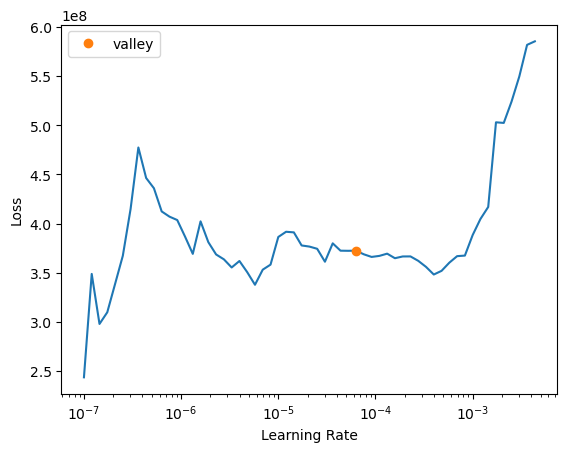

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10,lr_max=1e-4,wd=0.1)

epoch,train_loss,valid_loss,time
0,463752384.000000,390580512.000000,00:08
1,513132544.000000,886195328.000000,00:08
2,528690720.000000,1785890048.000000,00:08
3,597021952.000000,470242112.000000,00:08
4,541548928.000000,366129024.000000,00:08
5,509931136.000000,412959200.000000,00:08
6,471381600.000000,377111712.000000,00:08
7,442928384.000000,398048704.000000,00:08
8,415480256.000000,361367008.000000,00:08
9,394238304.000000,384502208.000000,00:08


可以使用

## 查看结果

In [ ]:
def getvidds(num, dls=dls):
    ds = dls.valid_ds[num]
    inp = torch.istft(ds[0], 511).cpu().numpy()
    targ = torch.istft(ds[1], 511).cpu().numpy()
    see = m(torch.unsqueeze(ds[0],0).cuda()).cpu().detach()
    pred = torch.istft(see, 511).reshape(-1).numpy()
    return inp, targ, pred,see

In [ ]:
inp,targ,pred,see = getvidds(1)

In [ ]:
see.shape

torch.Size([1, 256, 1344, 2])

<matplotlib.image.AxesImage>

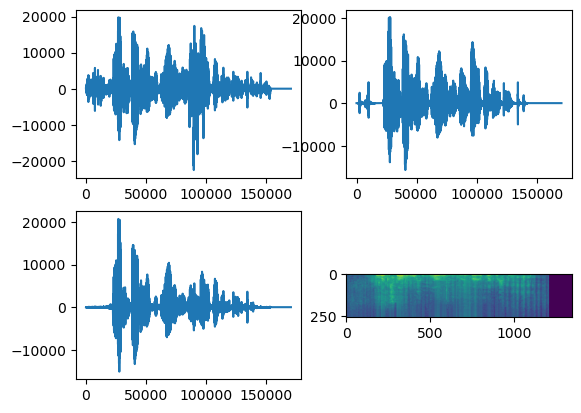

In [ ]:
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
ax1.plot(inp)
ax2.plot(targ)
ax3.plot(pred)
ax4.imshow(np.log1p(see[0,:,:,0].abs()))

听听看

In [ ]:
playarr(inp)

In [ ]:
playarr(targ)

In [ ]:
playarr(pred)

效果...还可以吧

### 保存

In [ ]:
learn.save('unet_voice')

Path('models/unet_voice.pth')

In [ ]:
learn.load('unet_voice')

<fastai.learner.Learner>

In [ ]:
#| hide
!rm -r models/*

rm: cannot remove 'models/*': No such file or directory
